In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [62]:
df_1 = pd.read_csv('training/prices_round_1_day_-2.csv' , sep = ';')
df_2 = pd.read_csv('training/prices_round_1_day_-1.csv', sep = ';')
df_3 = pd.read_csv('training/prices_round_1_day_0.csv', sep = ';')
df_4 = pd.read_csv('training/prices_round_1_day_1.csv', sep = ';')
df_1['global_timestamp'] = df_1.apply(lambda x: x['day'] * 1000000 + x['timestamp'], axis = 1)
df_2['global_timestamp'] = df_2.apply(lambda x: x['day'] * 1000000 + x['timestamp'], axis = 1)
df_3['global_timestamp'] = df_3.apply(lambda x: x['day'] * 1000000 + x['timestamp'], axis = 1)
df_4['global_timestamp'] = df_4.apply(lambda x: x['day'] * 1000000 + x['timestamp'], axis = 1)
df = pd.concat([df_1, df_2, df_3, df_4])
df = df.drop(['profit_and_loss'], axis = 1)
df.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,global_timestamp
19989,1,999700,AMETHYSTS,9996,1,9995.0,29.0,NaN,NaN,10002,7,10004.0,1.0,10005.0,29.0,9999.0,1999700
19990,1,999800,STARFRUIT,5022,24,NaN,NaN,NaN,NaN,5027,8,5029.0,24.0,NaN,NaN,5024.5,1999800
19991,1,999800,AMETHYSTS,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,1999800
19992,1,999900,AMETHYSTS,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,1999900
19993,1,999900,STARFRUIT,5022,20,NaN,NaN,NaN,NaN,5029,20,NaN,NaN,NaN,NaN,5025.5,1999900


In [63]:
df_amethyst = df[df['product'] == 'AMETHYSTS'].reset_index()
df_starfruit = df[df['product'] == 'STARFRUIT'].reset_index()

In [26]:
def calculate_vwap(dataframe):
    """
    Calculate an approximate VWAP using multiple levels of order book data.
    
    Parameters:
    - dataframe: A pandas DataFrame with columns for multiple bid and ask prices and volumes.
    
    Returns:
    - vwap: The calculated VWAP as a float.
    """
    # Initialize variables to store the sum of price*volume products and the sum of volumes
    total_price_volume = 0
    total_volume = 0
    dataframe.fillna(0, inplace = True)
    
    # Iterate through the bid and ask levels
    for i in range(1, 4):  # Assuming 3 levels as per your DataFrame structure
        bid_price_col = f'bid_price_{i}'
        bid_volume_col = f'bid_volume_{i}'
        ask_price_col = f'ask_price_{i}'
        ask_volume_col = f'ask_volume_{i}'
        
        # Calculate the product of price and volume for both bid and ask, and add to total
        total_price_volume += (dataframe[bid_price_col] * dataframe[bid_volume_col])
        total_price_volume += (dataframe[ask_price_col] * dataframe[ask_volume_col])
        
        # Sum up the volumes for both bid and ask
        total_volume += dataframe[bid_volume_col]
        total_volume += dataframe[ask_volume_col]
    
    # Calculate and return the VWAP
    vwap = total_price_volume / total_volume
    return vwap


def calculate_imbalance(dataframe):
    flag = 0
    dataframe.fillna(0, inplace = True)
    bid_volume, ask_volume = 0, 0
    
    # Iterate through the bid and ask levels
    for i in range(1, 4):  # Assuming 3 levels as per your DataFrame structure
        bid_volume_col = f'bid_volume_{i}'
        ask_volume_col = f'ask_volume_{i}'
        
        # Calculate the product of price and volume for both bid and ask, and add to total
        
        # Sum up the volumes for both bid and ask
        bid_volume += dataframe[bid_volume_col]
        ask_volume += dataframe[ask_volume_col]
    
    if bid_volume > ask_volume:
        flag = 1
    elif bid_volume < ask_volume:
        flag = -1
    # Calculate and return the VWAP
    return abs(bid_volume - ask_volume), flag


def calculate_mean_best(dataframe):
    dataframe.fillna(0, inplace = True)

    best_bid, best_ask = float('inf'),  float('-inf')

    for i in range(1, 4):  # Assuming 3 levels as per your DataFrame structure
        bid_price_col = f'bid_price_{i}'
        ask_price_col = f'ask_price_{i}'
        bid = dataframe[bid_price_col] if dataframe[bid_price_col] else float('inf')
        ask = dataframe[ask_price_col] if dataframe[ask_price_col] else float('-inf')
        best_bid = min(best_bid, bid)
        best_ask = max(best_ask, ask)
    return (best_bid + best_ask) / 2
    

In [209]:
df['vwap'] = df.apply(calculate_vwap, axis = 1)
df_amethyst['vwap'] = df_amethyst.apply(calculate_vwap, axis = 1)
df_starfruit['vwap'] = df_starfruit.apply(calculate_vwap, axis = 1)

### Amethyst

In [210]:
df_amethyst['mid_MA_50'] = df_amethyst['mid_price'].rolling(50).mean()
df_amethyst['mid_MA_30'] = df_amethyst['mid_price'].rolling(30).mean()
df_amethyst['mid_MA_10'] = df_amethyst['mid_price'].rolling(10).mean()

df_amethyst['vwap_MA_50'] = df_amethyst['vwap'].rolling(50).mean()
df_amethyst['vwap_MA_30'] = df_amethyst['vwap'].rolling(30).mean()
df_amethyst['vwap_MA_10'] = df_amethyst['vwap'].rolling(10).mean()

df_amethyst['spread'] = df_amethyst['bid_price_1'] - df_amethyst['ask_price_1']
df_amethyst[['imbalance_volume', 'imbalance_volume_flag']] = df_amethyst.apply(calculate_imbalance, axis = 1, result_type='expand')


df_amethyst['mid_price_diff_1'] = df_amethyst['mid_price'].diff(periods = 1)
df_amethyst['mid_price_diff_5'] = df_amethyst['mid_price'].diff(periods = 5)
df_amethyst['vwap_diff_1'] = df_amethyst['vwap'].diff(periods = 1)
df_amethyst['vwap_diff_5'] = df_amethyst['vwap'].diff(periods = 5)
df_amethyst['imbalance_volume_signed'] = df_amethyst['imbalance_volume'] * df_amethyst['imbalance_volume_flag']


df_amethyst.describe()

,index,day,timestamp,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,vwap_MA_30,vwap_MA_10,spread,imbalance_volume,imbalance_volume_flag,mid_price_diff_1,mid_price_diff_5,vwap_diff_1,vwap_diff_5,imbalance_volume_signed
count,39997.000000,39997.000000,39997.000000,39997.000000,39997.000000,29774.000000,29774.000000,6878.000000,6878.000000,39997.000000,...,39968.000000,39988.000000,39997.000000,39997.000000,39997.000000,39996.000000,39992.000000,39996.000000,39992.000000,39997.000000
mean,9998.750281,-0.500113,499977.665825,9996.613971,8.208066,9995.290656,19.699301,9995.084181,23.123146,10003.375028,...,9999.996890,9999.996885,-6.761057,2.568668,0.000150,0.000000,0.000025,0.000000,-0.000002,0.013576
std,5773.141954,1.118014,288667.439497,1.940623,10.154520,0.634297,10.148630,0.300322,7.034706,1.953329,...,0.106109,0.182548,2.481703,4.018449,0.698676,2.115635,2.115640,0.818203,0.823585,4.769273
min,0.000000,-2.000000,0.000000,9995.000000,0.000000,9995.000000,1.000000,9995.000000,1.000000,9998.000000,...,9999.283440,9998.849188,-10.000000,0.000000,-1.000000,-7.000000,-7.000000,-7.974265,-7.800000,-29.000000
25%,4999.000000,-2.000000,250000.000000,9995.000000,1.000000,9995.000000,20.000000,9995.000000,22.000000,10004.000000,...,9999.941668,9999.962248,-8.000000,0.000000,0.000000,-1.000000,-1.000000,-0.086957,-0.086963,0.000000
50%,9999.000000,-1.000000,500000.000000,9996.000000,2.000000,9995.000000,23.000000,9995.000000,25.000000,10004.000000,...,9999.999082,9999.999422,-8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14999.000000,0.000000,750000.000000,9996.000000,20.000000,9995.000000,27.000000,9995.000000,27.000000,10005.000000,...,10000.043105,10000.035356,-6.000000,4.000000,0.000000,1.000000,1.000000,0.088221,0.086957,0.000000
max,19999.000000,1.000000,999900.000000,10002.000000,30.000000,10000.000000,48.000000,9998.000000,49.000000,10005.000000,...,10000.492826,10001.221343,-2.000000,37.000000,1.000000,7.000000,7.000000,7.279279,8.515152,37.000000


In [211]:
df_amethyst['mid_price'].max()

10003.5

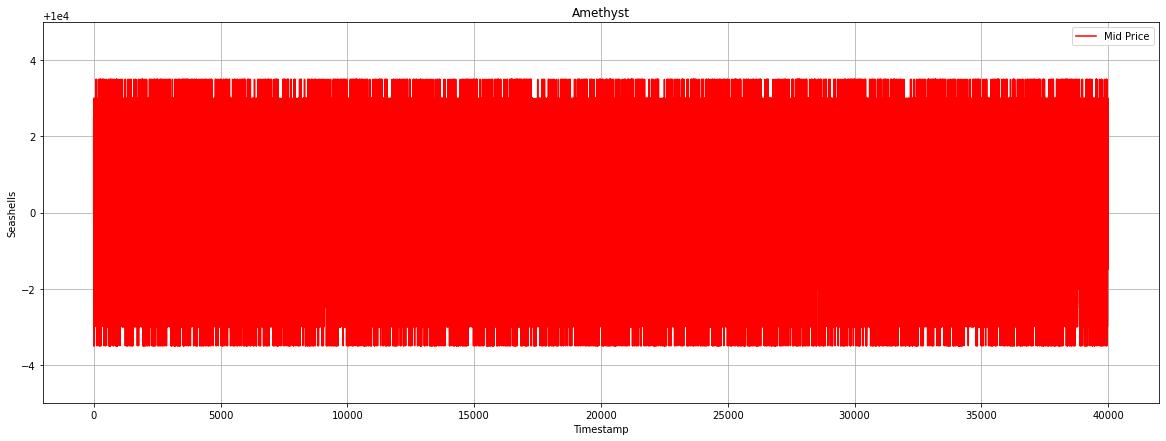

In [212]:
# df_amethyst.set_index('global_timestamp', inplace=True)
plt.figure(figsize=(20, 7))
# plt.plot(df_amethyst['vwap'], label = 'VWAP', color = 'g', linestyle='--')
plt.plot(df_amethyst['mid_price'], label = 'Mid Price', color = 'r')
# plt.plot(df_amethyst['MA_10'], label = 'MA_10', color = 'b', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_amethyst['MA_30'], label = 'MA_30', color = 'y', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_amethyst['MA_50'], label = 'MA_50', color = 'k', linewidth = 2, linestyle = 'dotted')


plt.title('Amethyst')
plt.ylim(9995, 10005)
plt.xlabel('Timestamp')
plt.ylabel('Seashells')
plt.legend()
plt.grid(True)
plt.show()

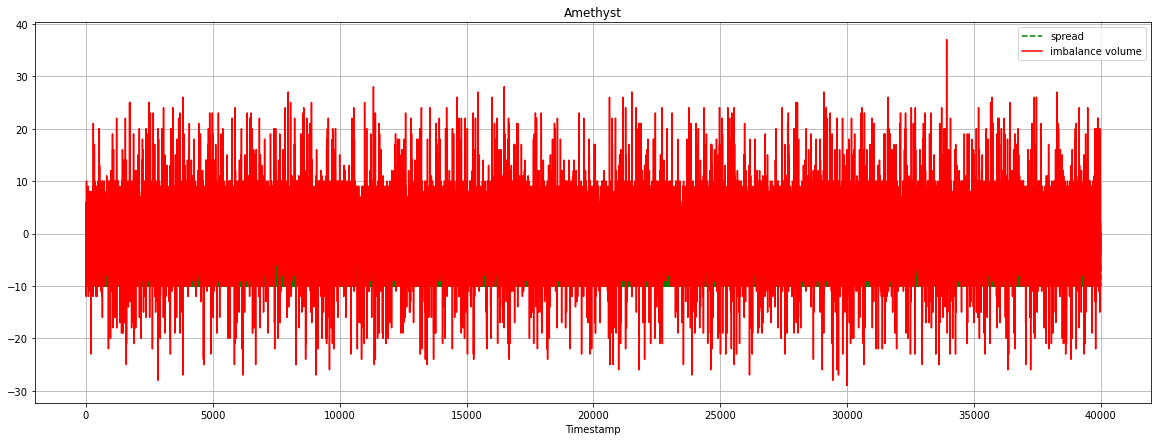

In [213]:
#df_amethyst.set_index('global_timestamp', inplace=True)
plt.figure(figsize=(20, 7))
plt.plot(df_amethyst['spread'], label = 'spread', color = 'g', linestyle='--')
plt.plot(df_amethyst['imbalance_volume'] * df_amethyst['imbalance_volume_flag'], label = 'imbalance volume', color = 'r')
# plt.plot(df_amethyst['MA_10'], label = 'MA_10', color = 'b', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_amethyst['MA_30'], label = 'MA_30', color = 'y', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_amethyst['MA_50'], label = 'MA_50', color = 'k', linewidth = 2, linestyle = 'dotted')


plt.title('Amethyst')
plt.xlabel('Timestamp')
plt.legend()
plt.grid(True)
plt.show()

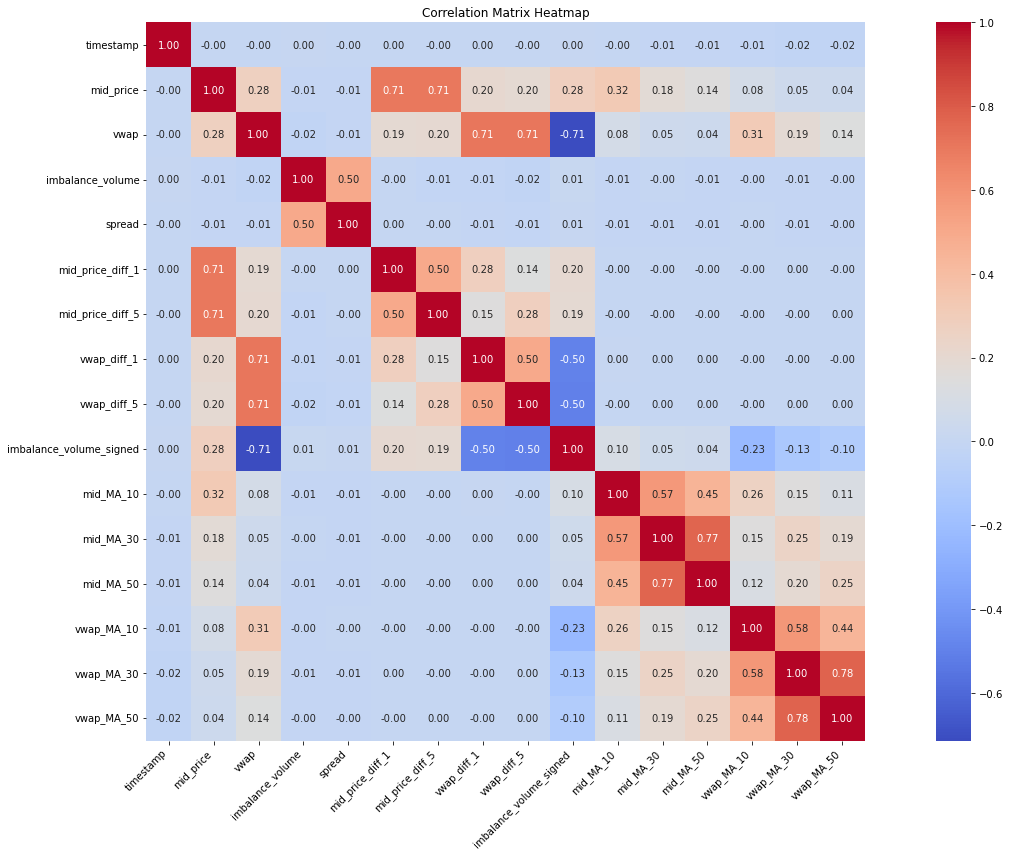

In [214]:

corr_columns = ['timestamp', 'mid_price', 'vwap', 'imbalance_volume', 'spread', 'mid_price_diff_1',
                 'mid_price_diff_5', 'vwap_diff_1', 'vwap_diff_5', 'imbalance_volume_signed', 'mid_MA_10',
                 'mid_MA_30', 'mid_MA_50', 'vwap_MA_10', 'vwap_MA_30', 'vwap_MA_50']
correlation_matrix = df_amethyst[corr_columns].corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Adding title and labels
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability

# Show the plot
plt.tight_layout()  # Adjust layout
plt.show()

### Starfruit

In [215]:
df_starfruit.head()

,index,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,global_timestamp,vwap
0,1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,5003,26,NaN,NaN,NaN,NaN,5000.0,-2000000,5000.000000
1,3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,5004,20,NaN,NaN,NaN,NaN,5002.0,-1999900,5000.156863
2,4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5000.0,-1999800,4999.516129
3,7,-2,300,STARFRUIT,4996,27,NaN,NaN,NaN,NaN,5003,27,NaN,NaN,NaN,NaN,4999.5,-1999700,4999.500000
4,9,-2,400,STARFRUIT,4995,20,NaN,NaN,NaN,NaN,5002,20,NaN,NaN,NaN,NaN,4998.5,-1999600,4998.500000


In [216]:
df_starfruit['mid_MA_50'] = df_starfruit['mid_price'].rolling(50).mean()
df_starfruit['mid_MA_30'] = df_starfruit['mid_price'].rolling(30).mean()
df_starfruit['mid_MA_10'] = df_starfruit['mid_price'].rolling(10).mean()

df_starfruit['vwap_MA_5'] = df_starfruit['vwap'].rolling(5).mean()
df_starfruit['vwap_MA_3'] = df_starfruit['vwap'].rolling(3).mean()
df_starfruit['vwap_MA_10'] = df_starfruit['vwap'].rolling(10).mean()

df_starfruit['spread'] = df_starfruit['bid_price_1'] - df_starfruit['ask_price_1']
df_starfruit[['imbalance_volume', 'imbalance_volume_flag']] = df_starfruit.apply(calculate_imbalance, axis = 1, result_type='expand')


df_starfruit['mid_price_diff_1'] = df_starfruit['mid_price'].diff(periods = 1)
df_starfruit['mid_price_diff_5'] = df_starfruit['mid_price'].diff(periods = 5)
df_starfruit['vwap_diff_1'] = df_starfruit['vwap'].diff(periods = 1)
df_starfruit['vwap_diff_5'] = df_starfruit['vwap'].diff(periods = 5)
df_starfruit['imbalance_volume_signed'] = df_starfruit['imbalance_volume'] * df_starfruit['imbalance_volume_flag']


df_starfruit['best_mean'] = df_starfruit.apply(calculate_mean_best, axis = 1)


df_starfruit.describe()

,index,day,timestamp,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,vwap_MA_10,spread,imbalance_volume,imbalance_volume_flag,mid_price_diff_1,mid_price_diff_5,vwap_diff_1,vwap_diff_5,imbalance_volume_signed,best_mean
count,39997.000000,39997.000000,39997.000000,39997.000000,39997.000000,15026.000000,15026.000000,1692.000000,1692.000000,39997.000000,...,39988.000000,39997.000000,39997.000000,39997.000000,39996.000000,39992.000000,39996.000000,39992.000000,39997.000000,39997.000000
mean,9998.750056,-0.500113,499977.665825,5032.842438,17.244618,5032.025622,23.074804,5032.447400,24.543735,5038.233793,...,5035.528309,-5.391354,2.008826,0.002050,0.000638,0.003213,0.000638,0.003276,0.022227,5035.536353
std,5773.142315,1.118014,288667.439497,28.776837,11.465095,28.861659,7.655111,28.178324,5.466838,28.817691,...,28.745440,1.941238,2.865732,0.707846,1.698817,1.876453,0.602127,1.009737,3.499629,28.752331
min,0.000000,-2.000000,0.000000,4948.000000,1.000000,4948.000000,1.000000,4949.000000,1.000000,4951.000000,...,4951.991690,-8.000000,0.000000,-1.000000,-7.000000,-8.500000,-4.218750,-5.020000,-25.000000,4951.500000
25%,4999.000000,-2.000000,250000.000000,5021.000000,3.000000,5020.000000,22.000000,5020.000000,22.000000,5027.000000,...,5023.852327,-7.000000,0.000000,0.000000,-1.000000,-1.000000,-0.190911,-0.852504,0.000000,5023.500000
50%,9998.000000,-1.000000,500000.000000,5039.000000,23.000000,5038.000000,25.000000,5038.000000,25.000000,5044.000000,...,5041.687150,-6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5041.500000
75%,14998.000000,0.000000,750000.000000,5052.000000,27.000000,5052.000000,28.000000,5052.000000,28.000000,5058.000000,...,5054.958618,-5.000000,4.000000,1.000000,1.000000,1.000000,0.189111,0.867760,1.000000,5055.000000
max,19999.000000,1.000000,999900.000000,5093.000000,48.000000,5092.000000,32.000000,5088.000000,45.000000,5095.000000,...,5091.641176,-1.000000,25.000000,1.000000,7.000000,8.000000,3.968750,4.787120,25.000000,5092.500000


In [217]:
df_starfruit.head()

,index,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,...,vwap_MA_10,spread,imbalance_volume,imbalance_volume_flag,mid_price_diff_1,mid_price_diff_5,vwap_diff_1,vwap_diff_5,imbalance_volume_signed,best_mean
0,1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,...,NaN,-6,0.0,0.0,NaN,NaN,NaN,NaN,0.0,5000.0
1,3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,...,NaN,-4,11.0,1.0,2.0,NaN,0.156863,NaN,11.0,5000.5
2,4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,...,NaN,-6,0.0,0.0,-2.0,NaN,-0.640734,NaN,0.0,4999.5
3,7,-2,300,STARFRUIT,4996,27,NaN,NaN,NaN,NaN,...,NaN,-7,0.0,0.0,-0.5,NaN,-0.016129,NaN,0.0,4999.5
4,9,-2,400,STARFRUIT,4995,20,NaN,NaN,NaN,NaN,...,NaN,-7,0.0,0.0,-1.0,NaN,-1.000000,NaN,0.0,4998.5


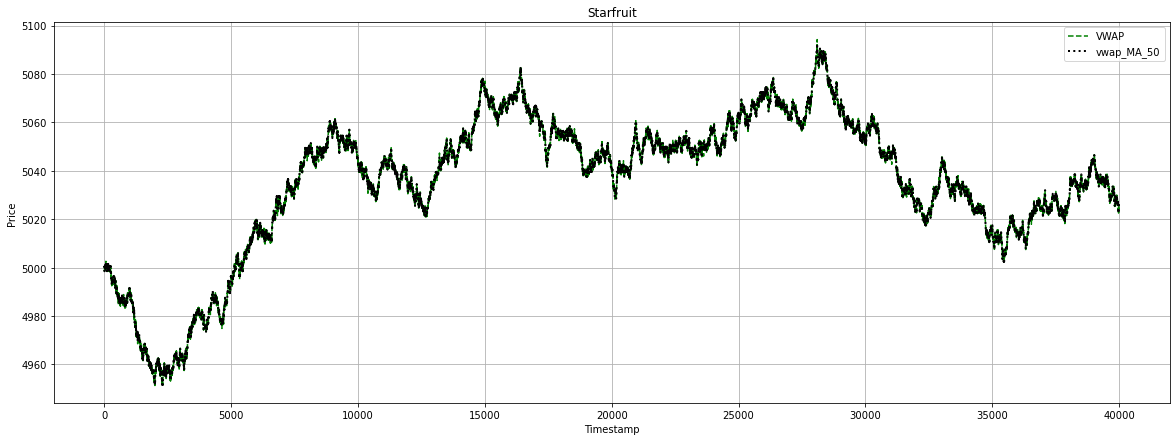

In [218]:
#df_amethyst.set_index('global_timestamp', inplace=True)
plt.figure(figsize=(20, 7))
plt.plot(df_starfruit['vwap'], label = 'VWAP', color = 'g', linestyle='--')
#plt.plot(df_starfruit['mid_price'], label = 'Mid Price', color = 'r')
# plt.plot(df_starfruit['MA_10'], label = 'MA_10', color = 'b', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_starfruit['MA_30'], label = 'MA_30', color = 'y', linewidth = 2, linestyle = 'dotted')
plt.plot(df_starfruit['best_mean'], label = 'vwap_MA_50', color = 'k', linewidth = 2, linestyle = 'dotted')

plt.title('Starfruit')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

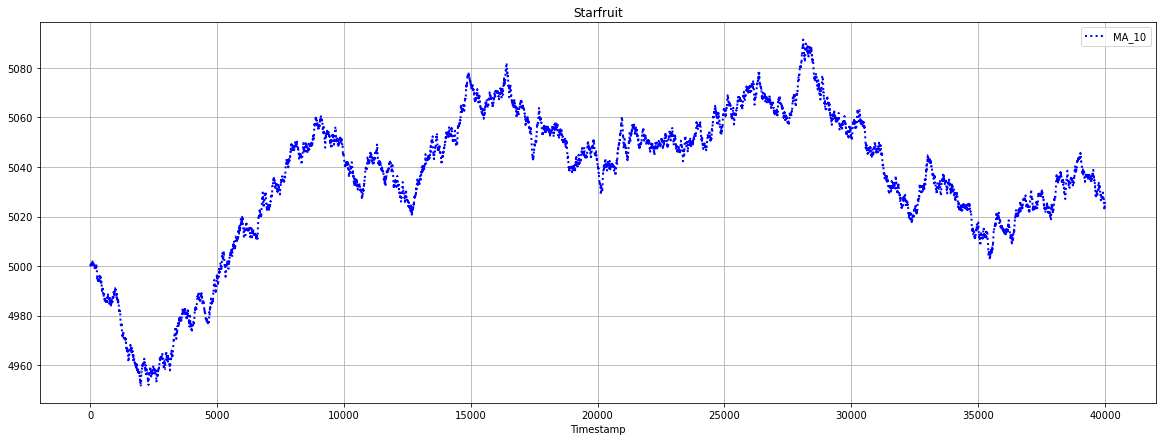

In [219]:
#df_amethyst.set_index('global_timestamp', inplace=True)
plt.figure(figsize=(20, 7))
# plt.plot(df_starfruit['spread'], label = 'spread', color = 'g', linestyle='--')
# plt.plot(df_starfruit['imbalance_volume'] * df_amethyst['imbalance_volume_flag'], label = 'imbalance volume', color = 'r')
plt.plot(df_starfruit['mid_MA_10'], label = 'MA_10', color = 'b', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_starfruit['MA_30'], label = 'MA_30', color = 'y', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_starfruit['MA_50'], label = 'MA_50', color = 'k', linewidth = 2, linestyle = 'dotted')


plt.title('Starfruit')
plt.xlabel('Timestamp')
plt.legend()
plt.grid(True)
plt.show()

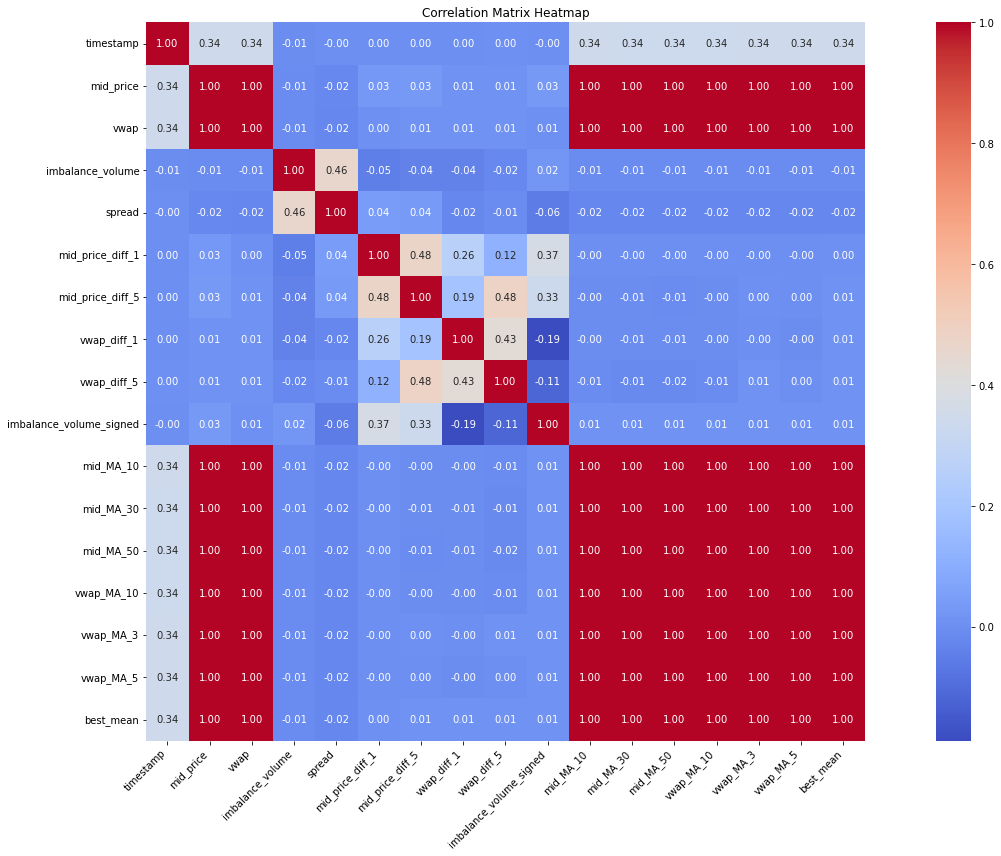

In [220]:
corr_columns = ['timestamp', 'mid_price', 'vwap', 'imbalance_volume', 'spread', 'mid_price_diff_1',
                 'mid_price_diff_5', 'vwap_diff_1', 'vwap_diff_5', 'imbalance_volume_signed', 'mid_MA_10',
                 'mid_MA_30', 'mid_MA_50', 'vwap_MA_10', 'vwap_MA_3', 'vwap_MA_5', 'best_mean']
correlation_matrix = df_starfruit[corr_columns].corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Adding title and labels
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability

# Show the plot
plt.tight_layout()  # Adjust layout
plt.show()

In [221]:
df_starfruit['vwap_change'] = df_starfruit['vwap'].diff().fillna(0)
df_starfruit['vwap_change_-1'] = df_starfruit['vwap'].shift(1)
df_starfruit['target'] = df_starfruit['vwap'].shift(-1)
df_starfruit['vwap_-1'] = df_starfruit['vwap'].shift(1)
df_starfruit['vwap_-2'] = df_starfruit['vwap'].shift(2)
df_starfruit['vwap_-3'] = df_starfruit['vwap'].shift(3)

df_starfruit['best_mean_-1'] = df_starfruit['best_mean'].shift(1)
df_starfruit['best_mean_-2'] = df_starfruit['best_mean'].shift(2)
df_starfruit['best_mean_-3'] = df_starfruit['best_mean'].shift(3)
df_starfruit['best_mean_-4'] = df_starfruit['best_mean'].shift(4)


df_starfruit['best_mean_MA_3'] = df_starfruit['best_mean'].rolling(3).mean()
df_starfruit['best_mean_MA_5'] = df_starfruit['best_mean'].rolling(5).mean()
df_starfruit['best_mean_MA_10'] = df_starfruit['best_mean'].rolling(10).mean()


df_starfruit[['vwap', 'target']].head(10)

,vwap,target
0,5000.000000,5000.156863
1,5000.156863,4999.516129
2,4999.516129,4999.500000
3,4999.500000,4998.500000
4,4998.500000,4999.524590
5,4999.524590,4999.500000
6,4999.500000,4999.517857
7,4999.517857,5000.489362
8,5000.489362,5000.516129
9,5000.516129,4999.750000


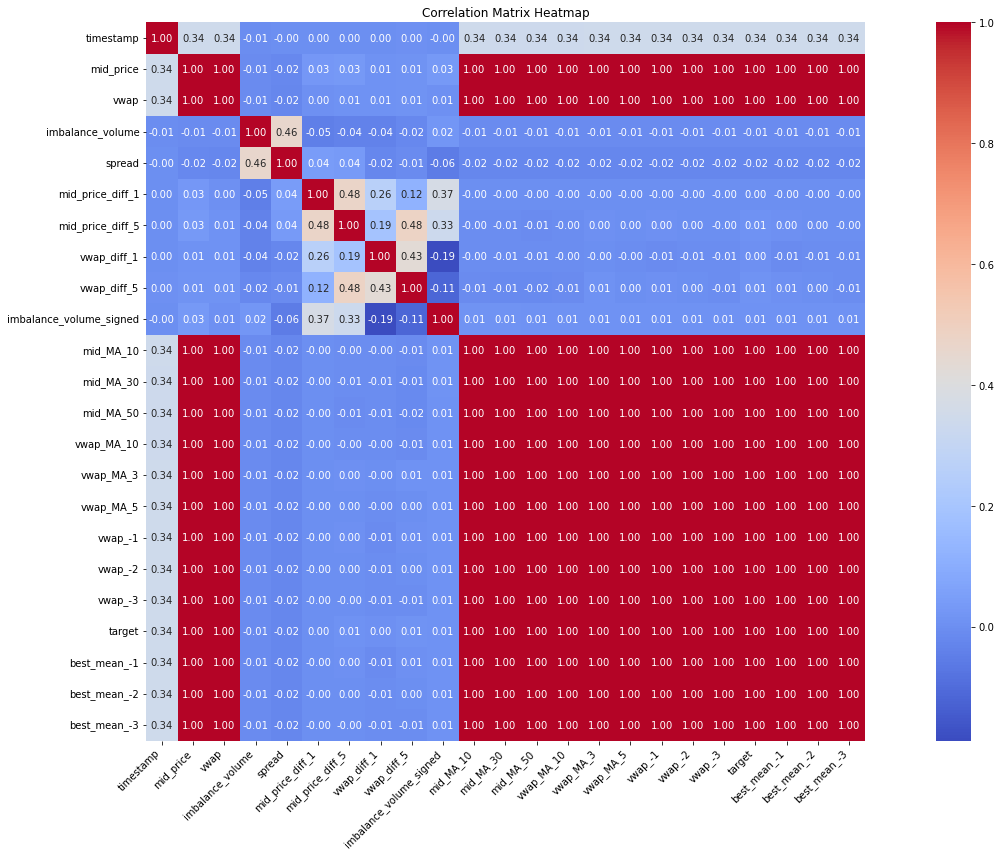

In [222]:
corr_columns = ['timestamp', 'mid_price', 'vwap', 'imbalance_volume', 'spread', 'mid_price_diff_1',
                 'mid_price_diff_5', 'vwap_diff_1', 'vwap_diff_5', 'imbalance_volume_signed', 'mid_MA_10',
                 'mid_MA_30', 'mid_MA_50', 'vwap_MA_10', 'vwap_MA_3', 'vwap_MA_5', 'vwap_-1', 'vwap_-2', 
                 'vwap_-3', 'target', 'best_mean_-1', 'best_mean_-2', 'best_mean_-3']
correlation_matrix = df_starfruit[corr_columns].corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Adding title and labels
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability

# Show the plot
plt.tight_layout()  # Adjust layout
plt.show()

In [223]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [224]:

# Assuming df_starfruit and X_columns are defined as per your code
X_columns = ['vwap', 'vwap_-1', 'vwap_-2', 'vwap_change', 'vwap_change_-1', 'imbalance_volume_signed',
             'best_mean', 'best_mean_-1', 'best_mean_-2', 'vwap_MA_3']
X = df_starfruit[X_columns].fillna(0)
y = df_starfruit['target'].fillna(0)

# Calculate the index to split the data
split_idx = int(len(X) * 0.8)

# Split the data into training and testing sets
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Fit the Linear Regression model on the training data
model = LinearRegression().fit(X_train, y_train)

# Predict the target for the testing data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error for the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the coefficients and intercept
for i in range(len(model.coef_)):
    print(f"\"{X_columns[i]}\": {model.coef_[i]},")

print("\nIntercept:", model.intercept_)

# Optionally calculate and print R-squared for the test set
r_squared_test = model.score(X_test, y_test)
print("\nR-squared (Test):", r_squared_test)

Mean Squared Error: 3157.268576110236
"vwap": 0.22285394391175223,
"vwap_-1": -0.07417284566873264,
"vwap_-2": -0.009922599548986569,
"vwap_change": -0.214375724476535,
"vwap_change_-1": -0.07417284566873111,
"imbalance_volume_signed": 0.002504372019541864,
"best_mean": 0.7769804958129451,
"best_mean_-1": 0.1481340709435021,
"best_mean_-2": 0.08332660516229784,
"vwap_MA_3": -0.0732249006665586,

Intercept: 0.9846641216790886

R-squared (Test): 0.02469425512851453


In [225]:
# Assuming df_starfruit and X_columns are defined as per your code
X_columns = ['vwap', 'vwap_change', 'imbalance_volume_signed',
             'best_mean', 'best_mean_-1', 'best_mean_-2']
X = df_starfruit[X_columns].fillna(0)
y = df_starfruit['target'].fillna(0)

# Calculate the index to split the data
split_idx = int(len(X) * 0.8)

# Split the data into training and testing sets
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Fit the Linear Regression model on the training data
model = LinearRegression().fit(X_train, y_train)

# Predict the target for the testing data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error for the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the coefficients and intercept
for i in range(len(model.coef_)):
    print(f"\"{X_columns[i]}\": {model.coef_[i]},")

print("\nIntercept:", model.intercept_)

# Optionally calculate and print R-squared for the test set
r_squared_test = model.score(X_test, y_test)
print("\nR-squared (Test):", r_squared_test)

Mean Squared Error: 3157.317308818134
"vwap": 0.1949211074012477,
"vwap_change": -0.21055265338929902,
"imbalance_volume_signed": 0.002488454759361457,
"best_mean": 0.8049108909253037,
"best_mean_-1": -0.00022361146695623613,
"best_mean_-2": 0.0001980202084325422,

Intercept: 0.9648770905787387

R-squared (Test): 0.024679201201732504


In [226]:

# Assuming df_starfruit and X_columns are defined as per your code
X_columns = ['vwap', 'vwap_change', 'imbalance_volume_signed']
X = df_starfruit[X_columns].fillna(0)
y = df_starfruit['target'].fillna(0)

# Calculate the index to split the data
split_idx = int(len(X) * 0.8)

# Split the data into training and testing sets
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Fit the Linear Regression model on the training data
model = LinearRegression(fit_intercept = False).fit(X_train, y_train)

# Predict the target for the testing data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error for the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the coefficients and intercept
for i in range(len(model.coef_)):
    print(f"\"{X_columns[i]}\": {model.coef_[i]},")

print("\nIntercept:", model.intercept_)

# Optionally calculate and print R-squared for the test set
r_squared_test = model.score(X_test, y_test)
print("\nR-squared (Test):", r_squared_test)

Mean Squared Error: 3157.3445552699163
"vwap": 0.999999979818508,
"vwap_change": -0.250350489592013,
"imbalance_volume_signed": 0.02607450235312586,

Intercept: 0.0

R-squared (Test): 0.02467078455287597


In [227]:

# Assuming df_starfruit and X_columns are defined as per your code
X_columns = ['vwap','best_mean', 'best_mean_-1', 'best_mean_-2', ]
X = df_starfruit[X_columns].fillna(0)
y = df_starfruit['target'].fillna(0)

# Calculate the index to split the data
split_idx = int(len(X) * 0.8)

# Split the data into training and testing sets
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Fit the Linear Regression model on the training data
model = LinearRegression().fit(X_train, y_train)

# Predict the target for the testing data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error for the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the coefficients and intercept
for i in range(len(model.coef_)):
    print(f"\"{X_columns[i]}\": {model.coef_[i]},")

print("\nIntercept:", model.intercept_)

# Optionally calculate and print R-squared for the test set
r_squared_test = model.score(X_test, y_test)
print("\nR-squared (Test):", r_squared_test)

Mean Squared Error: 3157.27237793233
"vwap": -0.04901122813883315,
"best_mean": 1.0487225234418114,
"best_mean_-1": -0.00014098179110266784,
"best_mean_-2": 0.00019691031631130507,

Intercept: 1.1588020204098939

R-squared (Test): 0.024693080714985993


In [228]:

# Assuming df_starfruit and X_columns are defined as per your code
X_columns = ['vwap', 'vwap_-1', 'vwap_-2', 'vwap_change', 'vwap_change_-1', 'imbalance_volume_signed', 'vwap_MA_3']
X = df_starfruit[X_columns].fillna(0)
y = df_starfruit['target'].fillna(0)

# Calculate the index to split the data
split_idx = int(len(X) * 0.8)

# Split the data into training and testing sets
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Fit the Linear Regression model on the training data
model = LinearRegression().fit(X_train, y_train)

# Predict the target for the testing data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error for the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the coefficients and intercept
for i in range(len(model.coef_)):
    print(f"\"{X_columns[i]}\": {model.coef_[i]},")

print("\nIntercept:", model.intercept_)

# Optionally calculate and print R-squared for the test set
r_squared_test = model.score(X_test, y_test)
print("\nR-squared (Test):", r_squared_test)

Mean Squared Error: 3157.3304436904637
"vwap": 0.9998504960844417,
"vwap_-1": -0.00010424757850810003,
"vwap_-2": 0.0933653554038299,
"vwap_change": -0.23711063720086106,
"vwap_change_-1": -0.00010424757850795434,
"imbalance_volume_signed": 0.025645145834636115,
"vwap_MA_3": -0.09318686708638167,

Intercept: 0.9043823228967085

R-squared (Test): 0.024675143733660976


In [229]:
# Assuming df_starfruit and X_columns are defined as per your code
X_columns = ['best_mean', 'best_mean_-1', 'best_mean_-2', 'best_mean_-3',]
X = df_starfruit[X_columns].fillna(0)
y = df_starfruit['target'].fillna(0)

# Calculate the index to split the data
split_idx = int(len(X) * 0.8)

# Split the data into training and testing sets
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Fit the Linear Regression model on the training data
model = LinearRegression().fit(X_train, y_train)

# Predict the target for the testing data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error for the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the coefficients and intercept
for i in range(len(model.coef_)):
    print(f"\"{X_columns[i]}\": {model.coef_[i]},")

print("\nIntercept:", model.intercept_)

# Optionally calculate and print R-squared for the test set
r_squared_test = model.score(X_test, y_test)
print("\nR-squared (Test):", r_squared_test)


# Fit the Linear Regression model on the training data
model = LinearRegression().fit(X, y)

# Print the coefficients and intercept
for i in range(len(model.coef_)):
    print(f"\"{X_columns[i]}\": {model.coef_[i]},")

print("\nIntercept:", model.intercept_)

Mean Squared Error: 3157.2731258033614
"best_mean": 0.9997138863574907,
"best_mean_-1": -0.00013757761159426395,
"best_mean_-2": 0.00019245864556895155,
"best_mean_-3": 1.1766553027247595e-06,

Intercept: 1.145784190669474

R-squared (Test): 0.02469284969158858
"best_mean": 1.0012252201206766,
"best_mean_-1": -0.00011613099877059405,
"best_mean_-2": 0.0003941628661304437,
"best_mean_-3": -0.00023525537272049696,

Intercept: -6.523275510305211


In [230]:
# Assuming df_starfruit and X_columns are defined as per your code
X_columns = ['best_mean', 'best_mean_-1', 'best_mean_-2', 'best_mean_-3', 'vwap_MA_10', 'vwap_MA_3', 'vwap_MA_5']
X = df_starfruit[X_columns].fillna(0)
y = df_starfruit['target'].fillna(0)

# Calculate the index to split the data
split_idx = int(len(X) * 0.8)

# Split the data into training and testing sets
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Fit the Linear Regression model on the training data
model = LinearRegression().fit(X_train, y_train)

# Predict the target for the testing data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error for the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the coefficients and intercept
for i in range(len(model.coef_)):
    print(f"\"{X_columns[i]}\": {model.coef_[i]},")

print("\nIntercept:", model.intercept_)

# Optionally calculate and print R-squared for the test set
r_squared_test = model.score(X_test, y_test)
print("\nR-squared (Test):", r_squared_test)

Mean Squared Error: 3157.255357156022
"best_mean": 0.9997312285188941,
"best_mean_-1": -0.00011369488505194489,
"best_mean_-2": 0.15208934670304802,
"best_mean_-3": -0.0002026085734905219,
"vwap_MA_10": -8.510491870356972e-05,
"vwap_MA_3": -0.15194357835113684,
"vwap_MA_5": 0.00030055237812477877,

Intercept: 1.112519486596284

R-squared (Test): 0.024698338570158906


In [231]:
# Assuming df_starfruit and X_columns are defined as per your code
X_columns = ['best_mean', 'best_mean_-1', 'best_mean_-2', 'best_mean_-3', 'best_mean_MA_3', 'best_mean_MA_10', ]
X = df_starfruit[X_columns].fillna(0)
y = df_starfruit['target'].fillna(0)

# Calculate the index to split the data
split_idx = int(len(X) * 0.8)

# Split the data into training and testing sets
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Fit the Linear Regression model on the training data
model = LinearRegression().fit(X_train, y_train)

# Predict the target for the testing data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error for the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the coefficients and intercept
for i in range(len(model.coef_)):
    print(f"\"{X_columns[i]}\": {model.coef_[i]},")

print("\nIntercept:", model.intercept_)

# Optionally calculate and print R-squared for the test set
r_squared_test = model.score(X_test, y_test)
print("\nR-squared (Test):", r_squared_test)

Mean Squared Error: 3157.268656865476
"best_mean": 0.9997405216398104,
"best_mean_-1": -0.00011241936289901251,
"best_mean_-2": 0.15908394858187155,
"best_mean_-3": 4.524878141786861e-05,
"best_mean_MA_3": -0.1589370735568946,
"best_mean_MA_10": -3.493995141417013e-05,

Intercept: 1.0685766789638365

R-squared (Test): 0.024694230182569332


## ORCHIDS

In [232]:
df_1 = pd.read_csv('training/prices_round_2_day_-1.csv' , sep = ';')
df_2 = pd.read_csv('training/prices_round_2_day_0.csv', sep = ';')
df_3 = pd.read_csv('training/prices_round_2_day_1.csv', sep = ';')
df_1['global_timestamp'] = df_1.apply(lambda x: x['DAY'] * 1000000 + x['timestamp'], axis = 1)
df_2['global_timestamp'] = df_2.apply(lambda x: x['DAY'] * 1000000 + x['timestamp'], axis = 1)
df_3['global_timestamp'] = df_3.apply(lambda x: x['DAY'] * 1000000 + x['timestamp'], axis = 1)
df = pd.concat([df_1, df_2, df_3])
df.reset_index(drop=True)
df.head()

,timestamp,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,DAY,global_timestamp
0,0,1200.00,1.5,10.5,-2.0,2500.0000,79.00000,-1,-1000000.0
1,100,1201.75,1.5,9.5,-2.0,2499.4197,79.00410,-1,-999900.0
2,200,1201.75,1.5,9.5,-2.0,2498.8457,79.00821,-1,-999800.0
3,300,1201.75,1.5,9.5,-2.0,2498.2780,79.01234,-1,-999700.0
4,400,1201.75,1.5,9.5,-2.0,2497.7166,79.01649,-1,-999600.0


In [233]:
df.describe()

,timestamp,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,DAY,global_timestamp
count,30003.000000,30003.000000,30003.000000,30003.000000,30003.000000,30003.000000,30003.000000,30003.00000,3.000300e+04
mean,500000.000000,1103.617855,1.237043,9.728044,-3.405143,2777.073279,79.073562,0.00000,5.000000e+05
std,288708.812038,81.975222,0.287521,1.368582,1.235526,912.366591,9.366057,0.81651,8.660495e+05
min,0.000000,960.750000,0.700000,7.500000,-6.500000,1397.304900,59.999580,-1.00000,-1.000000e+06
25%,250000.000000,1039.250000,1.000000,8.500000,-4.500000,1973.018900,71.204712,-1.00000,-2.499500e+05
50%,500000.000000,1081.750000,1.300000,9.500000,-2.600000,2498.066200,78.579020,0.00000,5.000000e+05
75%,750000.000000,1195.750000,1.400000,10.500000,-2.400000,3619.445200,86.771817,1.00000,1.249950e+06
max,1000000.000000,1257.250000,2.100000,19.500000,-2.000000,4513.986300,97.513270,1.00000,2.000000e+06


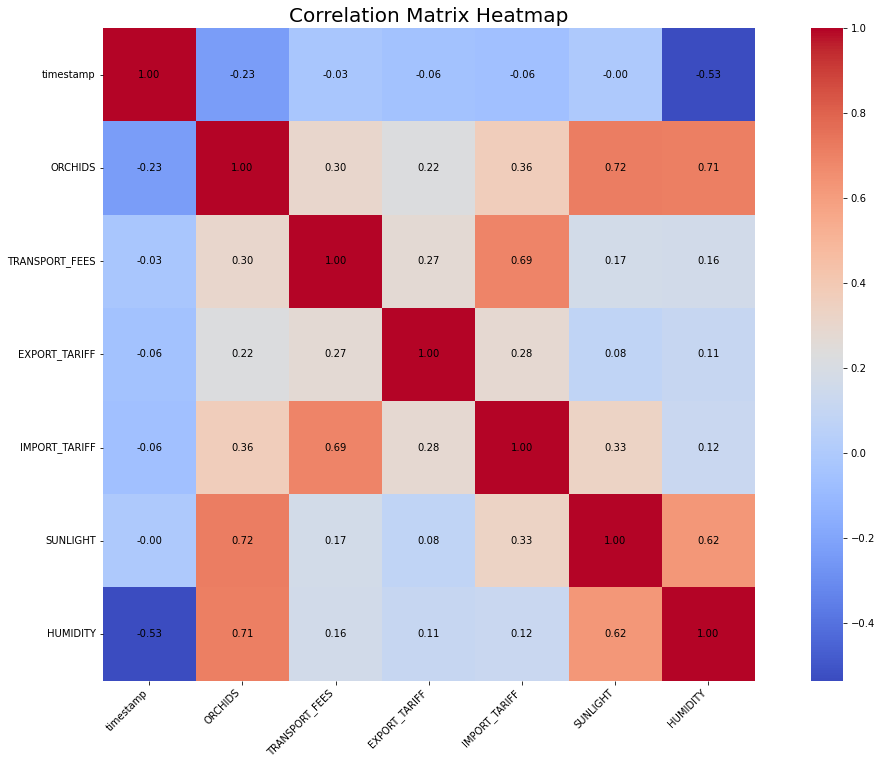

In [234]:
corr_columns = df.columns[:-2]
correlation_matrix = df[corr_columns].corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True,
            annot_kws={"color":"black"})

# Adding title and labels
plt.title('Correlation Matrix Heatmap', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=10)  # Ensure y-axis labels are horizontal for readability

# Show the plot
plt.show()


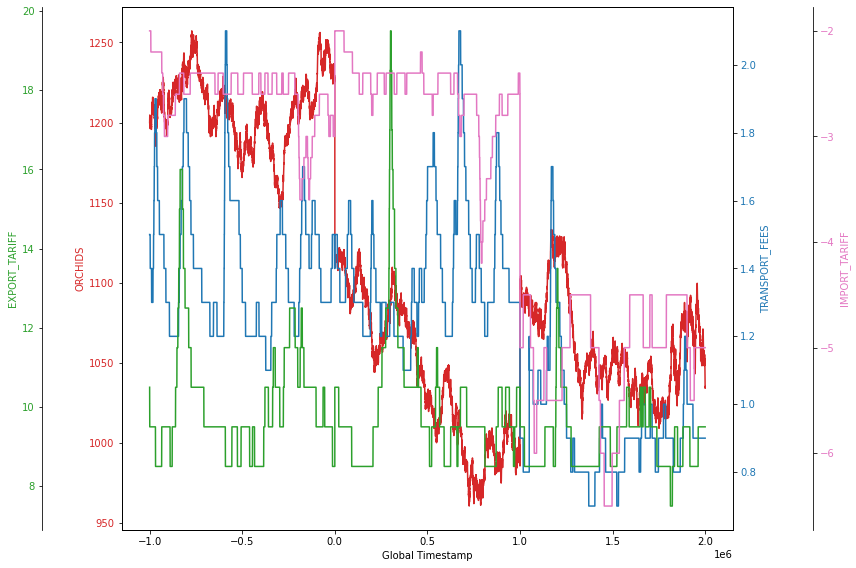

In [235]:


# Create initial subplot and first y-axis
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('Global Timestamp')
ax1.set_ylabel('ORCHIDS', color=color)
ax1.plot(df['global_timestamp'], df['ORCHIDS'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for 'TRANSPORT_FEES'
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('TRANSPORT_FEES', color=color)
ax2.plot(df['global_timestamp'], df['TRANSPORT_FEES'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Create third y-axis for 'EXPORT_TARIFF'
ax3 = ax1.twinx()
ax3.spines['right'].set_visible(False)  # Hide the original right spine
ax3.spines['left'].set_visible(True)  # Make the new left spine visible
ax3.yaxis.set_label_position('left')
ax3.yaxis.set_ticks_position('left')
ax3.spines['left'].set_position(('outward', 80))  # Outward on the left side
color = 'tab:green'
ax3.set_ylabel('EXPORT_TARIFF', color=color)
ax3.plot(df['global_timestamp'], df['EXPORT_TARIFF'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

# Create fourth y-axis for 'IMPORT_TARIFF'
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 80))
color = 'tab:pink'
ax4.set_ylabel('IMPORT_TARIFF', color=color)
ax4.plot(df['global_timestamp'], df['IMPORT_TARIFF'], color=color)
ax4.tick_params(axis='y', labelcolor=color)

# Show the plot with enough space for all axes
fig.tight_layout()
plt.show()


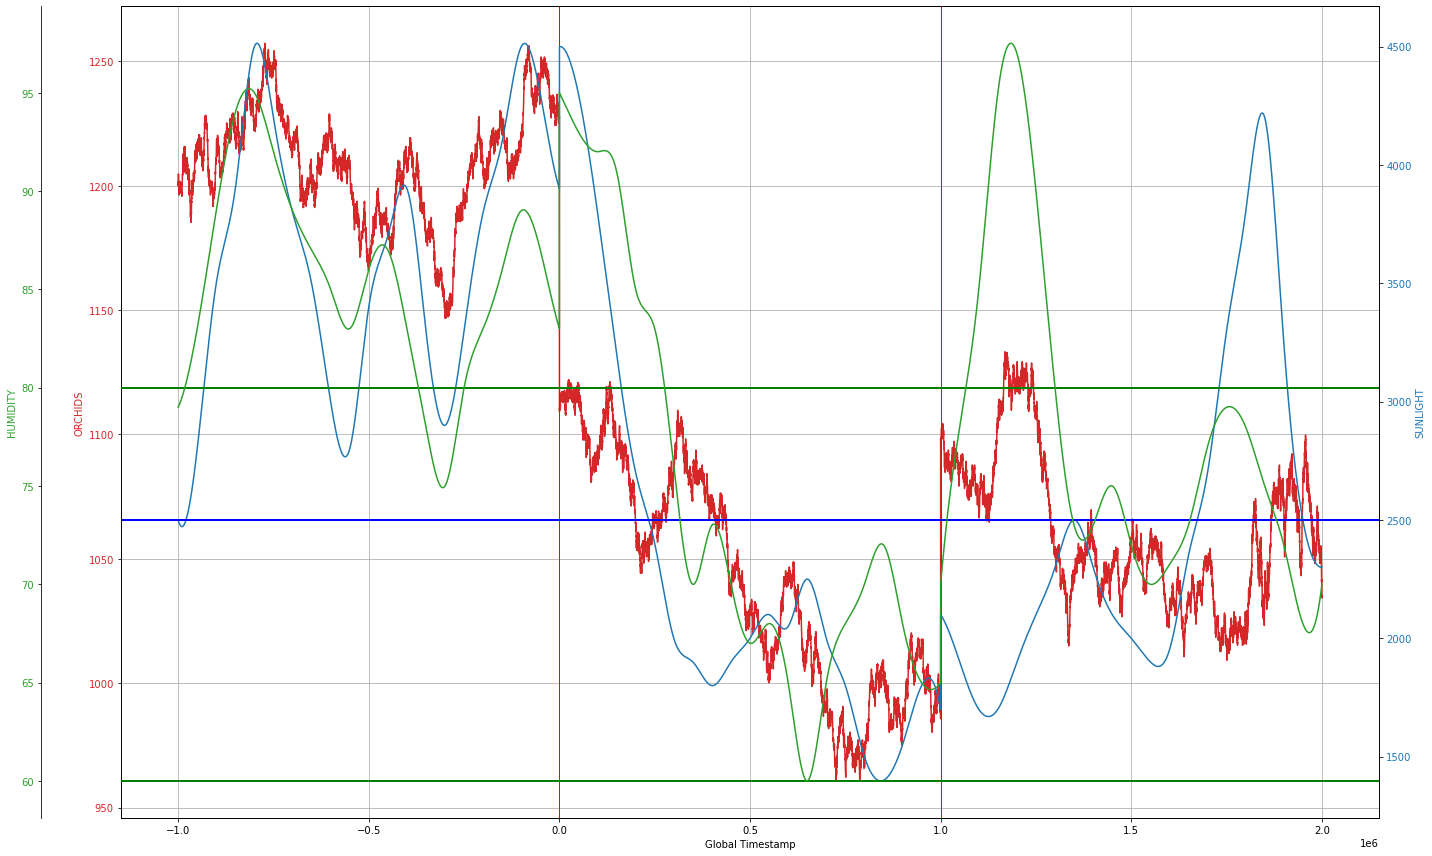

In [236]:


# Create initial subplot and first y-axis
fig, ax1 = plt.subplots(figsize=(20, 12))

color = 'tab:red'
ax1.set_xlabel('Global Timestamp')
ax1.set_ylabel('ORCHIDS', color=color)
ax1.plot(df['global_timestamp'], df['ORCHIDS'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(x=0, color='r', linestyle='-', linewidth=1)
ax1.axvline(x=1e6, color='r', linestyle='-', linewidth=1)


# Create second y-axis for 'TRANSPORT_FEES'
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('SUNLIGHT', color=color)
ax2.plot(df['global_timestamp'], df['SUNLIGHT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=2500, color='b', linestyle='-', linewidth=2)

# Create third y-axis for 'EXPORT_TARIFF'
ax3 = ax1.twinx()
ax3.spines['right'].set_visible(False)  # Hide the original right spine
ax3.spines['left'].set_visible(True)  # Make the new left spine visible
ax3.yaxis.set_label_position('left')
ax3.yaxis.set_ticks_position('left')
ax3.spines['left'].set_position(('outward', 80))  # Outward on the left side
color = 'tab:green'
ax3.set_ylabel('HUMIDITY', color=color)
ax3.axhline(y=80, color='g', linestyle='-', linewidth=2)
ax3.axhline(y=60, color='g', linestyle='-', linewidth=2)
ax3.plot(df['global_timestamp'], df['HUMIDITY'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax1.grid(True)
# Show the plot with enough space for all axes
fig.tight_layout()
plt.show()


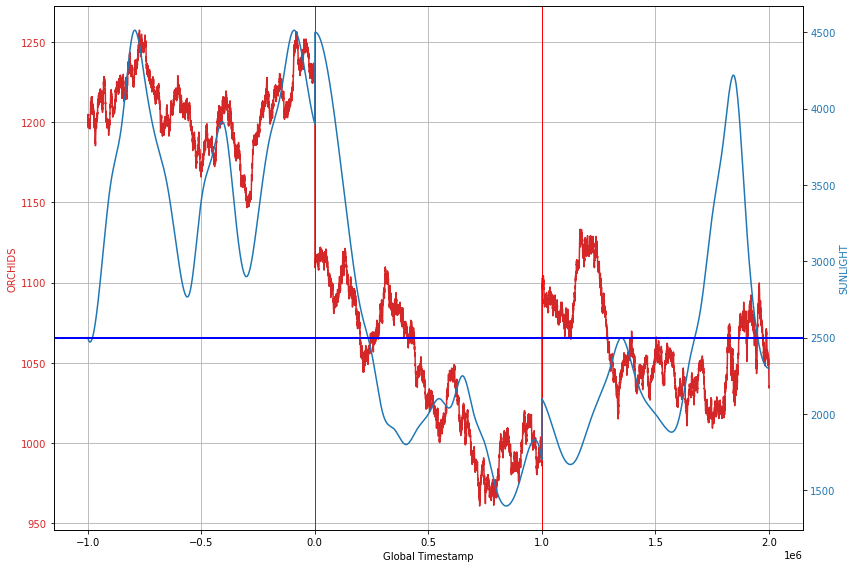

In [237]:
# Create initial subplot and first y-axis
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('Global Timestamp')
ax1.set_ylabel('ORCHIDS', color=color)
ax1.plot(df['global_timestamp'], df['ORCHIDS'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(x=0, color='r', linestyle='-', linewidth=1)
ax1.axvline(x=1e6, color='r', linestyle='-', linewidth=1)


# Create second y-axis for 'TRANSPORT_FEES'
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('SUNLIGHT', color=color)
ax2.plot(df['global_timestamp'], df['SUNLIGHT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=2500, color='b', linestyle='-', linewidth=2)


ax1.grid(True)
# Show the plot with enough space for all axes
fig.tight_layout()
plt.show()


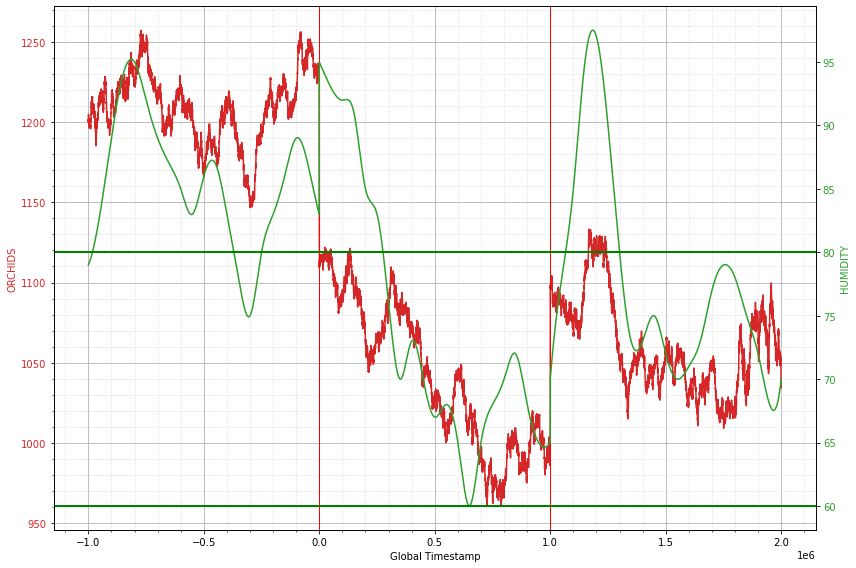

In [238]:
# Create initial subplot and first y-axis
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('Global Timestamp')
ax1.set_ylabel('ORCHIDS', color=color)
ax1.plot(df['global_timestamp'], df['ORCHIDS'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(x=0, color='r', linestyle='-', linewidth=1)
ax1.axvline(x=1e6, color='r', linestyle='-', linewidth=1)


# Create second y-axis for 'TRANSPORT_FEES'
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('HUMIDITY', color=color)
ax2.plot(df['global_timestamp'], df['HUMIDITY'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=80, color='g', linestyle='-', linewidth=2)
ax2.axhline(y=60, color='g', linestyle='-', linewidth=2)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-1e6, 2e6, 1e5)
minor_ticks = np.arange(-1e6, 2e6, 5e4)

ax1.grid(True, which = 'major')
ax1.grid(True, which = 'minor', color='#DDDDDD', linestyle=':', linewidth=1)
ax1.minorticks_on()

fig.tight_layout()
plt.show()


In [239]:
target_sunlight = 2500 * 7

sunlights, humidities = [], []

for _, row in df.iterrows():
    sunlights.append(row['SUNLIGHT'])
    humidities.append(row['HUMIDITY'])

sunlights = np.array(sunlights)
humidities = np.array(humidities)

In [240]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming `sunlights` is a list with sunlight data for all timesteps.
# Example list (replace with actual data):
sunlights_today = sunlights[10001:20002]

# Calculate sunlight_so_far for each timestep
timesteps = np.arange(0, 10001)  # Timesteps starting from 1 to the length of sunlights
hour_per_step = 12 / 10000 

# Calculate cumulative sunlight until each timestep
sunlight_so_far = np.cumsum(np.array(sunlights_today) * hour_per_step)

finite_diff = np.diff(sunlights_today)  # finite differences
finite_diff = np.insert(finite_diff, 0, finite_diff[0])  # Assume first rate is same as the second

# Convert finite_diff to a rate of sunlight change per timestep
sunlight_change_rate = finite_diff / hour_per_step

# Forecast the sunlight for each remaining timestep using the last known rate
forecasted_sunlight = [sunlights_today[0]]
for i in range(1, len(sunlights_today)):
    add_val = (finite_diff[i] * sunlights_today[i - 1] + sunlights_today[i - 1])
    remaining_value = (10001 - i) * hour_per_step * add_val
    forecasted_sunlight.append(remaining_value)

forecasted_sunlight = np.array(forecasted_sunlight)

# Calculate predicted sunlight for the whole day
predicted_sunlight = np.array([sunlight_so_far[i] + forecasted_sunlight[i] for i in range(len(sunlights_today))])

# Check if predicted sunlight is greater than the threshold for each timestep
threshold = 7 * 2500
predicted_above_threshold = predicted_sunlight > threshold

# Print out the predicted sunlight and whether it is above the threshold
print(predicted_sunlight)
print(predicted_above_threshold)


[ 4505.4        55933.20004273 55868.65621819 ... 27353.72273161
 27355.52657006 27357.34386612]
[False  True  True ...  True  True  True]


In [241]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming `sunlights` is a list with sunlight data for all timesteps.
# Example list (replace with actual data):
sunlights_today = sunlights[:10001]

# Calculate sunlight_so_far for each timestep
timesteps = np.arange(0, 10001)  # Timesteps starting from 1 to the length of sunlights
hour_per_step = 12 / 10000 

# Calculate cumulative sunlight until each timestep
sunlight_so_far = np.cumsum(np.array(sunlights_today) * hour_per_step)


# Forecast the sunlight for each remaining timestep using the last known rate
forecasted_sunlight = []
for i in range(len(sunlights_today)):
    add_val = sunlights_today[i]
    remaining_value = (10000 - i) * hour_per_step * add_val
    forecasted_sunlight.append(remaining_value)

forecasted_sunlight = np.array(forecasted_sunlight)

# Calculate predicted sunlight for the whole day
predicted_sunlight = np.array([sunlight_so_far[i] + forecasted_sunlight[i] for i in range(len(sunlights_today))])

# Check if predicted sunlight is greater than the threshold for each timestep
threshold = 7 * 2500
predicted_above_threshold = predicted_sunlight > threshold

# Print out the predicted sunlight and whether it is above the threshold
print(predicted_sunlight)
print(predicted_above_threshold)


[30003.         29996.0364     29989.1490888  ... 43441.34668752
 43441.34551848 43441.3449366 ]
[ True  True  True ...  True  True  True]


In [242]:
print(finite_diff)
print(sunlights_today)
print(sunlight_so_far)
print(forecasted_sunlight)
print(predicted_sunlight)

[ 0.0356  0.0356  0.0344 ... -0.891  -0.8945 -0.898 ]
[2500.     2499.4197 2498.8457 ... 3900.972  3900.4849 3900.    ]
[3.00000000e+00 5.99930364e+00 8.99791848e+00 ... 4.34319844e+04
 4.34366649e+04 4.34413449e+04]
[3.00000000e+04 2.99900371e+04 2.99801512e+04 ... 9.36233280e+00
 4.68058188e+00 0.00000000e+00]
[30003.         29996.0364     29989.1490888  ... 43441.34668752
 43441.34551848 43441.3449366 ]


In [243]:
import statsmodels.api as sm
import pandas as pd

df_orchids = df.copy()

def out_humidity(x):
    if x > 80:
        return x - 80
    elif x < 60:
        return 60 - x

    return 0
# Let's assume df_orchids is your DataFrame that includes ORCHIDS prices, sunlight, and humidity
# Add binary variables for specific humidity conditions
df_orchids['out_humidity'] = df_orchids['HUMIDITY'].apply(out_humidity)

# Define the independent variables (predictors) and the dependent variable (response)
X = df_orchids[['SUNLIGHT', 'HUMIDITY', 'out_humidity']]
y = df_orchids['ORCHIDS']

# Add a constant to the predictors to include an intercept in the model
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print out the statistics
model_summary = model.summary()
print(model_summary)


                            OLS Regression Results                            
Dep. Variable:                ORCHIDS   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                 1.786e+04
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        23:24:13   Log-Likelihood:            -1.5941e+05
No. Observations:               30003   AIC:                         3.188e+05
Df Residuals:                   29999   BIC:                         3.189e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          540.0724      5.057    106.796   

In [10]:
def exponential_smoothing(prices, alpha=0.2):
    smoothed_prices = [prices[0]]  # Initialize the series with the first price
    for price in prices[1:]:
        last_smoothed = smoothed_prices[-1]
        new_smoothed = alpha * price + (1 - alpha) * last_smoothed
        smoothed_prices.append(new_smoothed)
    
    # The forecast for the next period is the last value in the smoothed series
    return smoothed_prices[-1]

# Example usage
prices = [10, 12, 13, 12, 14, 13, 15, 16, 17]
predicted_next_price = exponential_smoothing(prices)
print(f"The predicted next price for STARFRUIT is {predicted_next_price}")


The predicted next price for STARFRUIT is 14.007124480000003


## Basket

In [12]:
df_1 = pd.read_csv('training/prices_round_3_day_0.csv' , sep = ';')
df_2 = pd.read_csv('training/prices_round_3_day_1.csv', sep = ';')
df_3 = pd.read_csv('training/prices_round_3_day_2.csv', sep = ';')
df_1['global_timestamp'] = df_1.apply(lambda x: x['day'] * 1000000 + x['timestamp'], axis = 1)
df_2['global_timestamp'] = df_2.apply(lambda x: x['day'] * 1000000 + x['timestamp'], axis = 1)
df_3['global_timestamp'] = df_3.apply(lambda x: x['day'] * 1000000 + x['timestamp'], axis = 1)
df = pd.concat([df_1, df_2, df_3])
df = df.drop(['profit_and_loss'], axis = 1)
df.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,global_timestamp
39995,2,999800,GIFT_BASKET,69537,2,69536.0,18.0,69535.0,24.0,69547,2,69548.0,18.0,69550.0,24.0,69542.0,2999800
39996,2,999900,CHOCOLATE,7749,143,NaN,NaN,NaN,NaN,7751,143,NaN,NaN,NaN,NaN,7750.0,2999900
39997,2,999900,GIFT_BASKET,69551,1,69550.0,19.0,69549.0,20.0,69561,1,69562.0,19.0,69564.0,20.0,69556.0,2999900
39998,2,999900,STRAWBERRIES,3984,240,NaN,NaN,NaN,NaN,3985,92,3986.0,148.0,NaN,NaN,3984.5,2999900
39999,2,999900,ROSES,14411,59,NaN,NaN,NaN,NaN,14412,59,NaN,NaN,NaN,NaN,14411.5,2999900


In [37]:
df_gift_basket = df[df['product'] == 'GIFT_BASKET'].reset_index(drop=True)
df_chocolate = df[df['product'] == 'CHOCOLATE'].reset_index(drop=True)
df_strawberries = df[df['product'] == 'STRAWBERRIES'].reset_index(drop=True)
df_roses = df[df['product'] == 'ROSES'].reset_index(drop=True)

In [38]:
print(f"GIFT_BASKET, {df_gift_basket['mid_price'].mean()}")
print(f"CHOCOLATE, {df_chocolate['mid_price'].mean()}")
print(f"STRAWBERRIES, {df_strawberries['mid_price'].mean()}")
print(f"ROSES, {df_roses['mid_price'].mean()}")
# 4 `CHOCOLATE` bars + 6 `STRAWBERRIES` + 1 `ROSES`
print(f"combined_basket, {4 * df_chocolate['mid_price'].mean() + 6 * df_strawberries['mid_price'].mean() + df_roses['mid_price'].mean()}")

GIFT_BASKET, 70708.80063333333
CHOCOLATE, 7915.34725
STRAWBERRIES, 4026.83735
ROSES, 14506.89705
combined_basket, 70329.31015


In [39]:
df_gift_basket['best_mean'] = df_gift_basket.apply(calculate_mean_best, axis = 1)
df_chocolate['best_mean'] = df_chocolate.apply(calculate_mean_best, axis = 1)
df_strawberries['best_mean'] = df_strawberries.apply(calculate_mean_best, axis = 1)
df_roses['best_mean'] = df_roses.apply(calculate_mean_best, axis = 1)

In [28]:
print(f"GIFT_BASKET, {df_gift_basket['best_mean'].mean()}")
print(f"CHOCOLATE, {df_chocolate['best_mean'].mean()}")
print(f"STRAWBERRIES, {df_strawberries['best_mean'].mean()}")
print(f"ROSES, {df_roses['best_mean'].mean()}")
# 4 `CHOCOLATE` bars + 6 `STRAWBERRIES` + 1 `ROSES`
print(f"combined_basket, {4 * df_chocolate['best_mean'].mean() + 6 * df_strawberries['best_mean'].mean() + df_roses['best_mean'].mean()}")

GIFT_BASKET, 70708.7918
CHOCOLATE, 7915.346866666667
STRAWBERRIES, 4026.839
ROSES, 14506.895916666666
combined_basket, 70329.31738333333


In [50]:
combined_basket_best_mean = 4 * df_chocolate['best_mean'] + 6 * df_strawberries['best_mean'] + df_roses['best_mean'] + 370
combined_basket_mid = 4 * df_chocolate['mid_price'] + 6 * df_strawberries['mid_price'] + df_roses['mid_price'] + 370

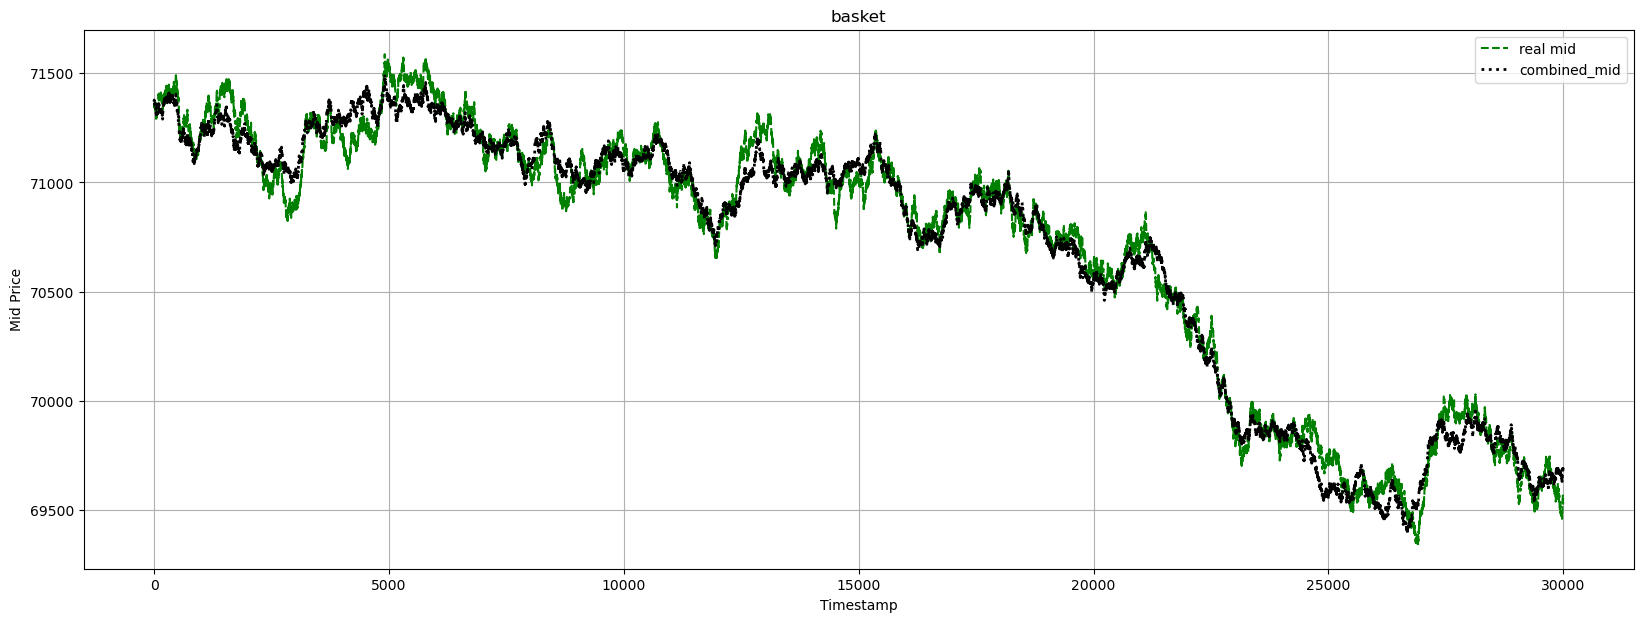

In [51]:
#df_amethyst.set_index('global_timestamp', inplace=True)
plt.figure(figsize=(20, 7))
plt.plot(df_gift_basket['mid_price'], label = 'real mid', color = 'g', linestyle='--')
#plt.plot(df_starfruit['mid_price'], label = 'Mid Price', color = 'r')
# plt.plot(df_starfruit['MA_10'], label = 'MA_10', color = 'b', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_starfruit['MA_30'], label = 'MA_30', color = 'y', linewidth = 2, linestyle = 'dotted')
plt.plot(combined_basket_mid, label = 'combined_mid', color = 'k', linewidth = 2, linestyle = 'dotted')

plt.title('basket')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.legend()
plt.grid(True)
plt.show()

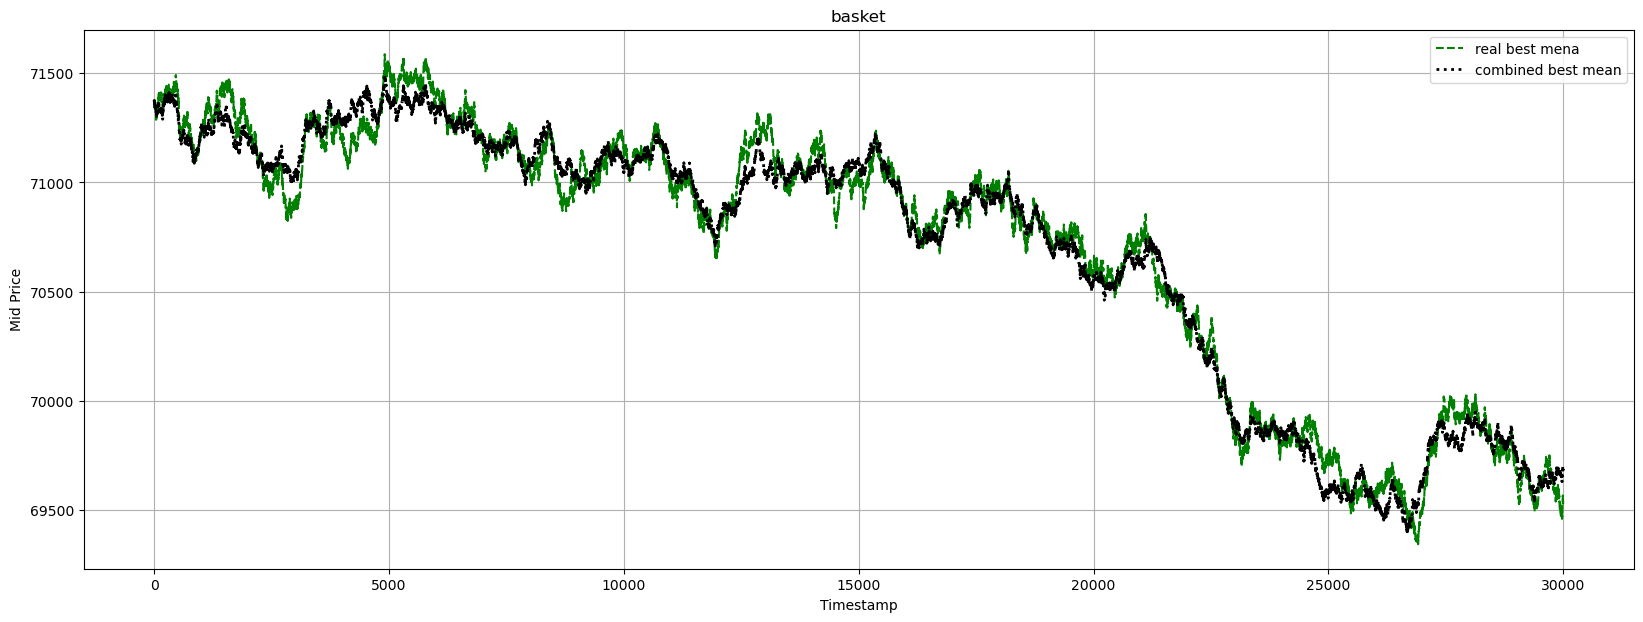

In [52]:
#df_amethyst.set_index('global_timestamp', inplace=True)
plt.figure(figsize=(20, 7))
plt.plot(df_gift_basket['best_mean'], label = 'real best mena', color = 'g', linestyle='--')
#plt.plot(df_starfruit['mid_price'], label = 'Mid Price', color = 'r')
# plt.plot(df_starfruit['MA_10'], label = 'MA_10', color = 'b', linewidth = 2, linestyle = 'dotted')
# plt.plot(df_starfruit['MA_30'], label = 'MA_30', color = 'y', linewidth = 2, linestyle = 'dotted')
plt.plot(combined_basket_best_mean, label = 'combined best mean', color = 'k', linewidth = 2, linestyle = 'dotted')

plt.title('basket')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.legend()
plt.grid(True)
plt.show()

600.0915149766495


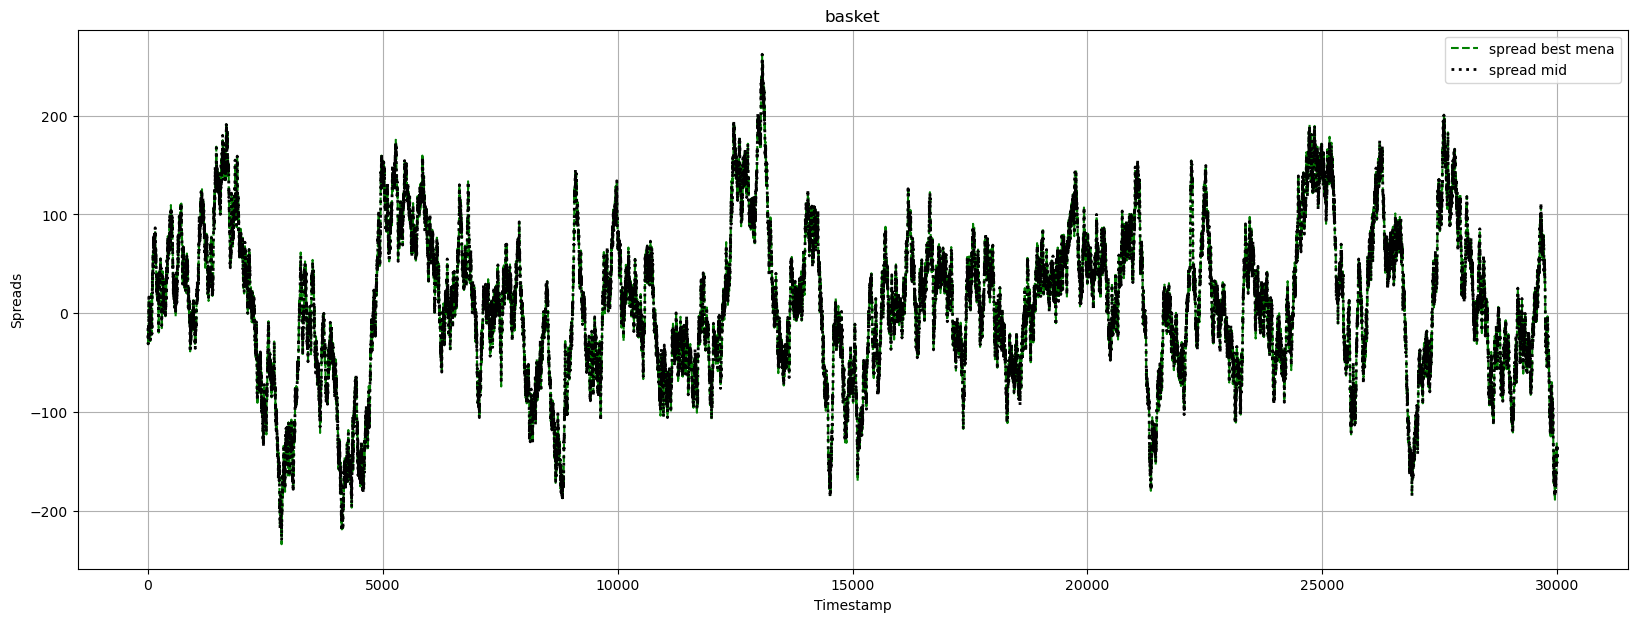

In [56]:
print(df_gift_basket['best_mean'].std())
best_mean_spreads = [df_gift_basket.loc[i, 'best_mean'] - combined_basket_best_mean[i] for i in range(len(combined_basket_best_mean))]
mid_spreads = [df_gift_basket.loc[i, 'mid_price'] - combined_basket_mid[i] for i in range(len(combined_basket_best_mean))]

#df_amethyst.set_index('global_timestamp', inplace=True)
plt.figure(figsize=(20, 7))
plt.plot(best_mean_spreads, label = 'spread best mena', color = 'g', linestyle='--')
plt.plot(mid_spreads, label = 'spread mid', color = 'k', linewidth = 2, linestyle = 'dotted')

plt.title('basket')
plt.xlabel('Timestamp')
plt.ylabel('Spreads')
plt.legend()
plt.grid(True)
plt.show()

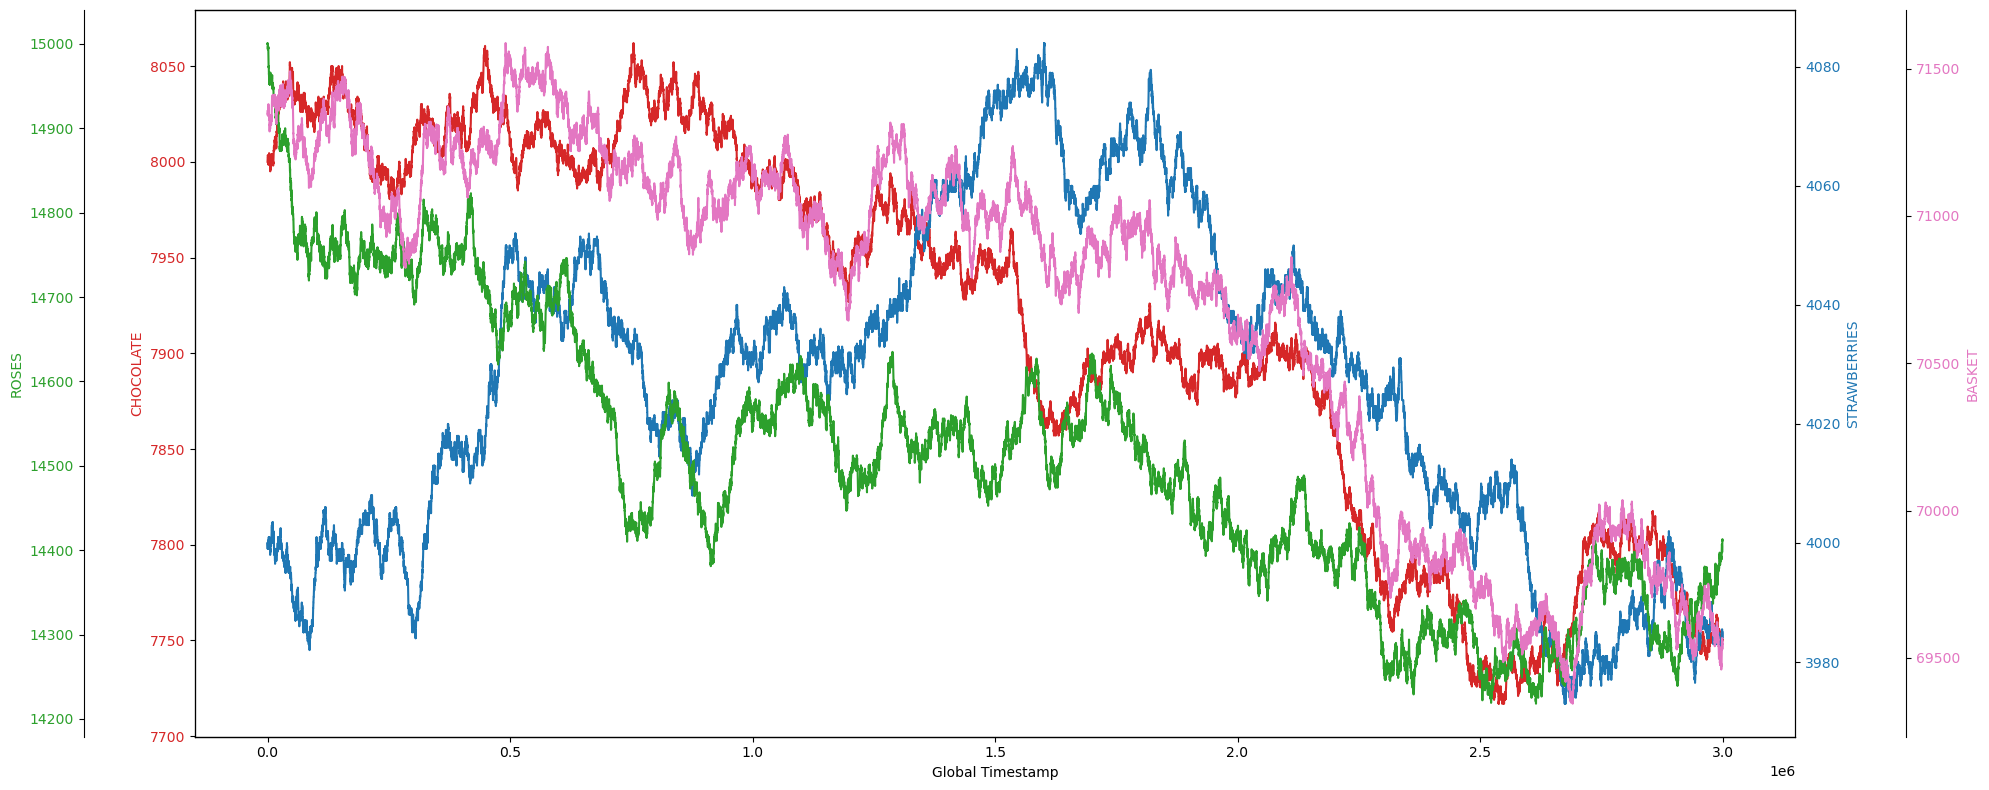

In [58]:
# Create initial subplot and first y-axis
fig, ax1 = plt.subplots(figsize=(20, 8))

color = 'tab:red'
ax1.set_xlabel('Global Timestamp')
ax1.set_ylabel('CHOCOLATE', color=color)
ax1.plot(df_chocolate['global_timestamp'], df_chocolate['best_mean'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for 'TRANSPORT_FEES'
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('STRAWBERRIES', color=color)
ax2.plot(df_strawberries['global_timestamp'], df_strawberries['best_mean'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Create third y-axis for 'EXPORT_TARIFF'
ax3 = ax1.twinx()
ax3.spines['right'].set_visible(False)  # Hide the original right spine
ax3.spines['left'].set_visible(True)  # Make the new left spine visible
ax3.yaxis.set_label_position('left')
ax3.yaxis.set_ticks_position('left')
ax3.spines['left'].set_position(('outward', 80))  # Outward on the left side
color = 'tab:green'
ax3.set_ylabel('ROSES', color=color)
ax3.plot(df_roses['global_timestamp'], df_roses['best_mean'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

# Create fourth y-axis for 'IMPORT_TARIFF'
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 80))
color = 'tab:pink'
ax4.set_ylabel('BASKET', color=color)
ax4.plot(df_gift_basket['global_timestamp'], df_gift_basket['best_mean'], color=color)
ax4.tick_params(axis='y', labelcolor=color)

# Show the plot with enough space for all axes
fig.tight_layout()
plt.show()


In [60]:
print(np.array(mid_spreads).std())
print(np.array(best_mean_spreads).std())

76.42310842343251
76.41898315968174
